# Ablation: Semi-Supervised Architope - for Reviews
---
- This code Implements Algorithm 3.2 of the "PC-NNs" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 0.9
min_width = 50
# Ablation Finess
N_plot_finess = 5
# min_parts_threshold = .001; max_parts_threshold = 0.9
N_min_parts = 1; N_max_plots = 4
Tied_Neurons_Q = False

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 10**4

def f_1(x):
    return x
def f_2(x):
    return x**2
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
#================================================#
 Training Datasize: 539 and test datasize: 60.  
#================================================#
#================================================#
 Training Datasize: 191 and test datasize: 21.  
#================================================#


### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

#### Explicit Partion Builder:
Implements exactly Algorithm 2:

In [7]:
def Random_Lipschitz_Partioner(X_in,
                               y_in,
                               N_parts_to_get=4):

    # Compute Size of each part
    size_part_reference = int(round(X_in.shape[0]/N_parts_to_get))

    # Apply random bijection #
    #------------------------#
    ## Get random bijection indices
    random_bijection_indices = np.random.choice(range(X_in.shape[0]),size=X_in.shape[0], replace=False)
    ## Apply random bijections
    X_in_shuffled = X_in[random_bijection_indices,:]
    y_in_shuffled = y_in[random_bijection_indices,:]

    # Initialize Lists #
    #------------------#
    X_parts = []
    y_parts = []

    for i_th_part_to_get in range(N_parts_to_get):
        # Build random balls #
        #--------------------#
        ## Sample random radius
        size_part = int(np.maximum(1,np.round(size_part_reference*np.random.uniform(low=.5,high=1.5,size=1)[0])))
        ## Sample random point
        X_center_loop_index = np.random.choice(range(X_in_shuffled.shape[0]),size=1, replace=False)
        X_center_loop = X_in_shuffled[X_center_loop_index,:]
        ## Compute Typical Distances from Center
        distances_loop = X_center_loop-X_in_shuffled
        distances_loop = np.linalg.norm(distances_loop, axis=1)

        # Remove Random Ball from Dataset
        if size_part <= len(distances_loop):
            ## Identify indices
            indices_smallest_to_random_ball = np.argsort(distances_loop)[:size_part]
        else:
            print('Final Loop')
            indices_smallest_to_random_ball = np.array(range(X_in_shuffled.shape[0]))
        ## Extract Parts
        X_current_part_loop = X_in_shuffled[indices_smallest_to_random_ball,:]
        y_current_part_loop = y_in_shuffled[indices_smallest_to_random_ball,:]
        ## Append to List of Parts
        X_parts.append(X_current_part_loop)
        y_parts.append(y_current_part_loop)

        # Remove Selected Entries From Array #
        #------------------------------------#
        X_in_shuffled = np.delete(X_in_shuffled,indices_smallest_to_random_ball,axis=0)
        y_in_shuffled = np.delete(y_in_shuffled,indices_smallest_to_random_ball,axis=0)

        # Failsafe if procedure has terminated
        if X_in_shuffled.shape[0] == 0:
            print('breaking early')
            break
    # Count Number of Parts Generated        
    N_parts_generated = len(X_parts)
    # Output Parts
    return X_parts, y_parts, N_parts_generated

# Ablation Function

In [8]:
def get_PCNNs(N_parts,X_train,y_train,X_test,y_test):

    # Initialization(s) #
    #-------------------#
    N_neurons = 0
    L_timer = 0
    P_timer = 0
    Mean_Width_Subnetworks = 0

    # Partitioner Begin #
    #-------------------#
    import time
    partitioning_time_begin = time.time()
    print('-------------------------------------------------------')
    print('Randomly Initialized Parts - Via Randomized Algorithm 2')
    print('-------------------------------------------------------')
    X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(X_train.to_numpy(),
                                                                                         y_train.reshape(-1,1),
                                                                                         N_parts)
    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(N_parts_Generated_by_Algo_2)+'.')
    ############# Partitioner End ########

    print('-----------------------------------------------------')
    print('Training Sub-Networks on Each Randomly Generated Part')
    print('-----------------------------------------------------')
    # Time-Elapse (Start) for Training on Each Part #
    PCNN_timer = time.time(); PCNN_timer = -math.inf; N_params_Architope = 0; N_params_tally = 0
    # Remove Eager Execution Error(s)
    tf.compat.v1.disable_eager_execution()
    # Automatically Initialize Correct Input/Output Dimension(s)
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]; param_grid_Vanilla_Nets['output_dim'] = [1]
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    # Decide if/or not to tie neuron numbers of sub-patterns together
    if Tied_Neurons_Q == True:
        param_grid_Vanilla_Nets['height'] = [int(np.maximum(round(param_grid_Vanilla_Nets['height'][0]/N_parts),min_width))]
        param_grid_Deep_Classifier['height'] = [int(np.maximum(round(param_grid_Deep_Classifier['height'][0]/N_parts),min_width))]

    for current_part in range(N_parts_Generated_by_Algo_2):
        # Update User #
        #-------------#
        print('-----------------------------------------------------------')
        print('Currently Training Part: '+str(current_part)+'/'+str(N_parts_Generated_by_Algo_2 )+'Total Parts.')
        print('-----------------------------------------------------------')

        # Timer for Part
        part_training_timer = time.time()
        # Get Data for Sub-Pattern
        X_loop = pd.DataFrame(X_parts_list[current_part])
        y_loop = (y_parts_list[current_part]).reshape(-1,)
        # Train ffNN
        y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN(n_folds = 4, 
                                                                              n_jobs = n_jobs,
                                                                              n_iter = n_iter, 
                                                                              param_grid_in = param_grid_Vanilla_Nets, 
                                                                              X_train= X_loop, 
                                                                              y_train=y_loop,
                                                                              X_test_partial=X_train,
                                                                              X_test=X_test,
                                                                              NOCV=True)
        # Reshape y
        ## Training
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop.shape = (y_hat_part_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        ## Testing
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop_test.shape = (y_hat_part_loop_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])

        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_part_loop-y_train)).reshape(y_hat_part_loop.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_part_loop.reshape(y_hat_part_loop.shape[0],1)
            predictions_test = y_hat_part_loop_test.reshape(y_hat_part_loop_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_part_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_part_loop_test.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #==============================#
        # Update Performance Metric(s) #
        #==============================#
        part_training_timer = time.time() - part_training_timer
        # L-Time
        L_timer += partitioning_time
        # P-Time
        P_timer = max(P_timer,part_training_timer)
        # N. Params
        N_neurons += N_neurons_PCNN_loop
        # Mean Width for Sub-Network(s)
        Mean_Width_Subnetworks += param_grid_Vanilla_Nets['height'][0]

    # Take Mean of Width(s)
    Mean_Width_Subnetworks = Mean_Width_Subnetworks/N_parts_Generated_by_Algo_2
    print('-----------------------')
    print('Training Deep Zero-Sets')
    print('-----------------------')


    # Time Elapsed for Training Deep Zero-Sets
    Deep_Zero_Sets_timer = time.time()

    ## Initialize Classes Labels
    partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    ## Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    ## Convert to integers
    partition_labels_training = partition_labels_training+0
    ## Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # Get Binary Classes (Discontinuous Unit)
    ## Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    ## Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    # Get PC-NN Prediction(s)
    ## Train
    PCNN_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    ## Test
    PCNN_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)

    # End Timer
    Deep_Zero_Sets_timer = time.time() - Deep_Zero_Sets_timer

    print('-----------------------------------')
    print('Computing Final Performance Metrics')
    print('-----------------------------------')
    # Time-Elapsed Training Deep Classifier

    # Update Times
    L_timer +=Deep_Zero_Sets_timer
    P_timer +=Deep_Zero_Sets_timer
    # Update Number of Neurons Used
    N_neurons_subPatterns = N_neurons
    N_neurons_deep_Zero_Sets = (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    N_neurons = N_neurons_deep_Zero_Sets + N_neurons_subPatterns



    # Compute Peformance
    performance_PCNN = reporter(y_train_hat_in=PCNN_prediction_y_train,y_test_hat_in=PCNN_prediction_y_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    # Write Performance
    performance_PCNN.to_latex((results_tables_path+"PCNN_full_performance.tex"))

    # Update User
    print(performance_PCNN)

    ### Model Complexity/Efficiency Metrics
    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_neurons - np.log((performance_PCNN['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_neurons) *(performance_PCNN['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    PCNN_Model_Complexity = pd.DataFrame({'L-time': [L_timer],
                                               'P-time':[P_timer],
                                               'N_params_expt': [N_neurons],
                                               'AIC-like': [AIC_like],
                                               'Eff': [Efficiency],
                                               'N. Parts':[N_parts_Generated_by_Algo_2]})


    # Write Required Training Time(s)
    PCNN_Model_Complexity.to_latex((results_tables_path+"PCNN_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(PCNN_Model_Complexity)
    
    
    # Return Output(s)
    return performance_PCNN, PCNN_Model_Complexity, N_parts_Generated_by_Algo_2, N_neurons, N_neurons_subPatterns,N_neurons_deep_Zero_Sets, Mean_Width_Subnetworks

---
# Perform Ablation:
---

In [ ]:
# Initialize 
# q_implicit_N_parts_possibilities = np.linspace(min_parts_threshold,max_parts_threshold,N_plot_finess)
N_parts_possibilities = np.unique(np.round(np.linspace(N_min_parts,N_max_plots,num=N_plot_finess))).astype(int)

# Get Performance Metric
for inplicit_N_parts_loop in range(len(N_parts_possibilities)):
    ### UPDATE USER ###
    for k in range(10):
        print('--------------------------------------')
    print('Ablation Completion Percentage:',(inplicit_N_parts_loop/N_plot_finess))
    for k in range(10):
        print('--------------------------------------')
    
    # Implicitly Set: Current Number of Parts
#     q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    N_parts_possibilities_loop = N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, N_neurons_subPatterns_loop, N_neurons_deep_Zero_Sets_loop, height_mean_loop = get_PCNNs(N_parts_possibilities_loop,X_train,y_train,X_test,y_test)
#     performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, height_mean_loop = Ablate_PCNNs(q_implicit_N_parts_loop,data_y,X_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,6,1])

    # Record
    if inplicit_N_parts_loop == 0:
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_architope_hist = N_neurons_subPatterns_loop
        N_params_subPatterns_hist = N_neurons_subPatterns_loop
        N_neurons_deep_Zero_Sets_hist = 0
        height_mean_hist = height_mean_loop
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)
        N_params_subPatterns_hist = np.append(N_params_subPatterns_hist,N_neurons_subPatterns_loop)
        N_neurons_deep_Zero_Sets_hist = np.append(N_neurons_deep_Zero_Sets_hist,N_neurons_deep_Zero_Sets_loop)
        height_mean_hist = np.append(height_mean_hist,height_mean_loop)

# Cleanup
## Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]

# Write
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
mean_subpattern_widths_hist = (height_mean_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]
N_neurons_per_input = N_neurons_deep_Zero_Sets_hist + height_mean_hist

--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.0
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
-------------------------------------------------------
Randomly Initialized Parts - Via Randomized Algorithm 2
-------------------------------------------------------
The_parts_listhe

129/129 [==============================] - 0s 432us/sample - loss: 296.1766 - mse: 296142.1562 - mae: 296.1766 - mape: 136.3433
Epoch 50/50
129/129 [==============================] - 0s 401us/sample - loss: 296.0588 - mse: 295989.8125 - mae: 296.0588 - mape: 136.9484
-----------------------
Training Deep Zero-Sets
-----------------------
Train on 191 samples
191/191 [==============================] - 0s 2ms/sample - loss: 0.6073 - accuracy: 0.9058
-----------------------------------
Computing Final Performance Metrics
-----------------------------------
              train          test
MAE      427.240540    116.570597
MSE   462859.360941  20682.796877
MAPE    7096.332194   5721.800010
     L-time   P-time  N_params_expt  AIC-like     Eff  N. Parts
0  1.819232  6.83207           1800  3590.483  873.76         1
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------

49/49 [==============================] - 0s 378us/sample - loss: 240.9625 - mse: 109548.0000 - mae: 240.9624 - mape: 98.5186
Epoch 45/50
49/49 [==============================] - 0s 528us/sample - loss: 240.8810 - mse: 109485.0312 - mae: 240.8810 - mape: 98.4481
Epoch 46/50
49/49 [==============================] - 0s 373us/sample - loss: 240.8126 - mse: 109429.7031 - mae: 240.8126 - mape: 98.3669
Epoch 47/50
49/49 [==============================] - 0s 390us/sample - loss: 240.7391 - mse: 109369.8281 - mae: 240.7391 - mape: 98.3166
Epoch 48/50
49/49 [==============================] - 0s 399us/sample - loss: 240.6648 - mse: 109309.8125 - mae: 240.6648 - mape: 98.1940
Epoch 49/50
49/49 [==============================] - 0s 375us/sample - loss: 240.5939 - mse: 109261.3750 - mae: 240.5939 - mape: 98.1386
Epoch 50/50
49/49 [==============================] - 0s 357us/sample - loss: 240.5214 - mse: 109202.2969 - mae: 240.5214 - mape: 98.0486
-----------------------------------------------------

191/191 [==============================] - 0s 2ms/sample - loss: 5.4729 - accuracy: 0.5000
-----------------------------------
Computing Final Performance Metrics
-----------------------------------
             train          test
MAE   4.251865e+02  1.187417e+02
MSE   4.573583e+05  2.155971e+04
MAPE           inf           inf
     L-time    P-time  N_params_expt  AIC-like      Eff  N. Parts
0  1.896983  7.010054           2800  5590.446  942.498         2
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.4
--------------------------------------
--------------------------------------
---------------------------------

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/50
52/52 [==============================] - 0s 9ms/sample - loss: 322.2659 - mse: 244116.6406 - mae: 322.2658 - mape: 99.5211
Epoch 2/50
52/52 [==============================] - 0s 399us/sample - loss: 322.1055 - mse: 243948.9688 - mae: 322.1055 - mape: 99.3313
Epoch 3/50
52/52 [==============================] - 0s 392us/sample - loss: 321.9313 - mse: 243808.2500 - mae: 321.9313 - mape: 99.1035
Epoch 4/50
52/52 [==============================] - 0s 352us/sample - loss: 321.7504 - mse: 243644.7812 - mae: 321.7504 - mape: 98.8284
Epoch 5/50
52/52 [==============================] - 0s 369us/sample - loss: 321.6017 - mse: 243501.0781 - mae: 321.6017 - mape: 98.7433
Epoch 6/50
52/52 [==============================] - 0s 467us/sample - loss: 321.4577 - mse: 243367.8281 - mae: 321.4577 - mape: 98.5614
Epoch 7/50
52/52 [==============================] - 0s 518us/sample - loss: 321.2919 - mse: 243187.2812 - mae: 321.2919 - mape: 98.3472
Epoch 8/50
52/52 [==============================] 

34/34 [==============================] - 0s 430us/sample - loss: 271.6883 - mse: 439741.2500 - mae: 271.6883 - mape: 234.5165
Epoch 10/50
34/34 [==============================] - 0s 546us/sample - loss: 271.6615 - mse: 439712.3438 - mae: 271.6615 - mape: 234.4018
Epoch 11/50
34/34 [==============================] - 0s 446us/sample - loss: 271.6302 - mse: 439677.5625 - mae: 271.6302 - mape: 234.4661
Epoch 12/50
34/34 [==============================] - 0s 441us/sample - loss: 271.5945 - mse: 439631.5938 - mae: 271.5945 - mape: 234.9067
Epoch 13/50
34/34 [==============================] - 0s 460us/sample - loss: 271.5541 - mse: 439579.6250 - mae: 271.5541 - mape: 235.5494
Epoch 14/50
34/34 [==============================] - 0s 592us/sample - loss: 271.5115 - mse: 439520.4062 - mae: 271.5115 - mape: 236.4213
Epoch 15/50
34/34 [==============================] - 0s 476us/sample - loss: 271.4655 - mse: 439448.6250 - mae: 271.4655 - mape: 237.8188
Epoch 16/50
34/34 [===========================

75/75 [==============================] - 0s 462us/sample - loss: 415.2604 - mse: 398649.6562 - mae: 415.2604 - mape: 98.9127
Epoch 18/50
75/75 [==============================] - 0s 420us/sample - loss: 415.0802 - mse: 398375.5938 - mae: 415.0802 - mape: 98.8696
Epoch 19/50
75/75 [==============================] - 0s 516us/sample - loss: 414.9066 - mse: 398113.4375 - mae: 414.9066 - mape: 98.8214
Epoch 20/50
75/75 [==============================] - 0s 432us/sample - loss: 414.7252 - mse: 397800.6250 - mae: 414.7252 - mape: 98.7909
Epoch 21/50
75/75 [==============================] - 0s 427us/sample - loss: 414.5460 - mse: 397547.5938 - mae: 414.5460 - mape: 98.7402
Epoch 22/50
75/75 [==============================] - 0s 525us/sample - loss: 414.3489 - mse: 397263.5000 - mae: 414.3489 - mape: 98.6947
Epoch 23/50
75/75 [==============================] - 0s 402us/sample - loss: 414.1865 - mse: 397001.5000 - mae: 414.1866 - mape: 98.6691
Epoch 24/50
75/75 [==============================] - 

---

# Feedforward Neural Network (ffNN) Benchmark

---

In [12]:
# Record Model complexities for ffNNs
P_time_ffNN = P_Times[0]
L_time_ffNN = P_Times[0]
Width_ffNN = height_mean_hist[0]
# For: Plots
MAE_ffNN = np.repeat(performance_Architope_history_report_MAE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
MSE_ffNN = np.repeat(performance_Architope_history_report_MSE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
L_times_ffNN_plot = np.repeat(L_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
P_times_ffNN_plot = np.repeat(P_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_per_input_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
# Record in Table
ffNN_Model_Complexity = pd.DataFrame({'L-time': [L_time_ffNN],
                                               'P-time':[P_time_ffNN],
                                               'N_params_expt': [N_neurons_ffNN],
                                               'AIC-like': [0],
                                               'Eff': [0],
                                               'N. Parts':[1]})

---
## Plots
---

## MAE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


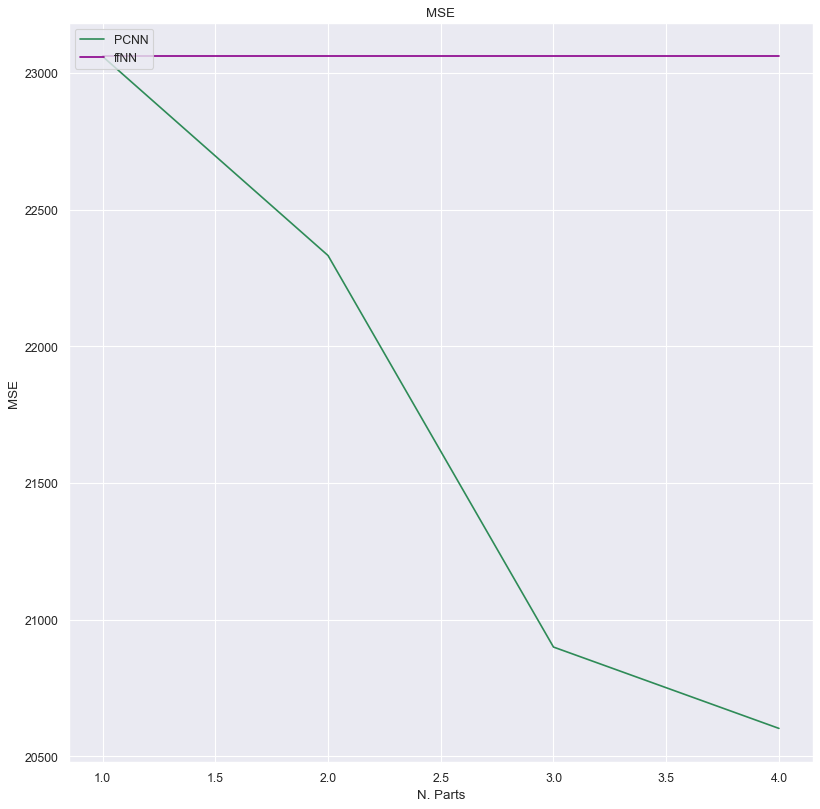

In [20]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test,
         label = 'PCNN',
         color='seagreen')
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MSE_ffNN,
         label = 'ffNN',
         color='darkmagenta')
# Add Legend
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()
plt.show()

## MAE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


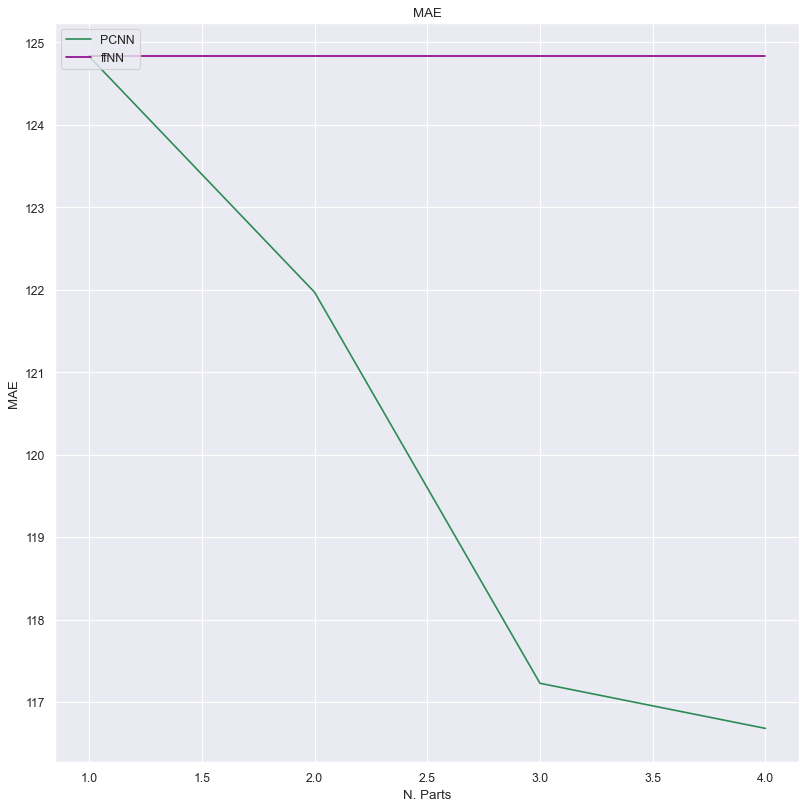

In [14]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test,
         label = 'PCNN',
         color='seagreen')
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MAE_ffNN,
         label = 'ffNN',
         color='darkmagenta')

# Export #
#--------#
# SAVE Figure to .eps
plt.legend(loc="upper left")
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# L-Time

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


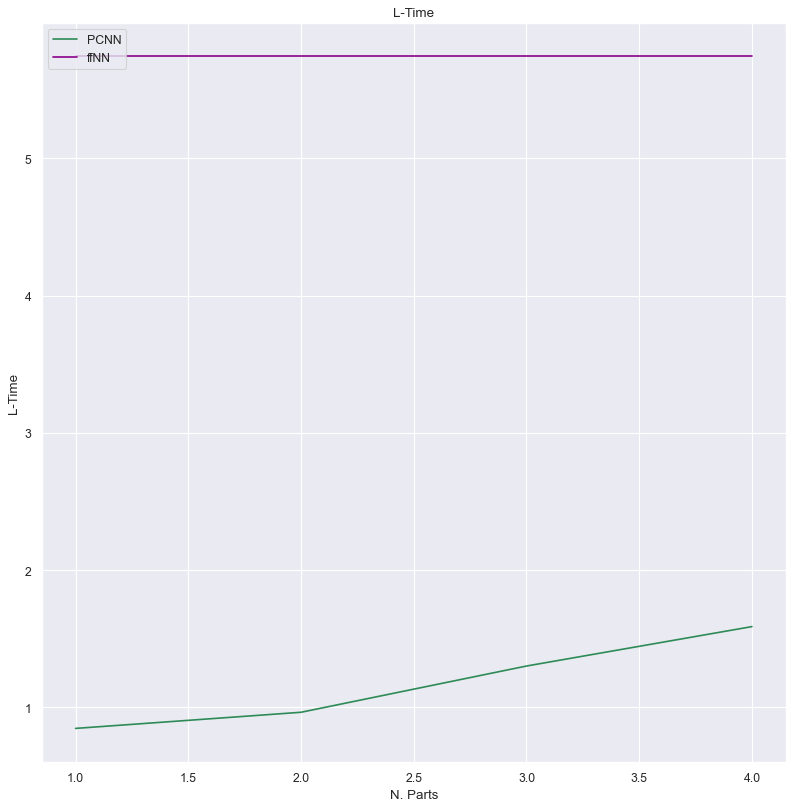

In [15]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times,
         label = 'PCNN',
         color='seagreen')
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta')
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# P-Times

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


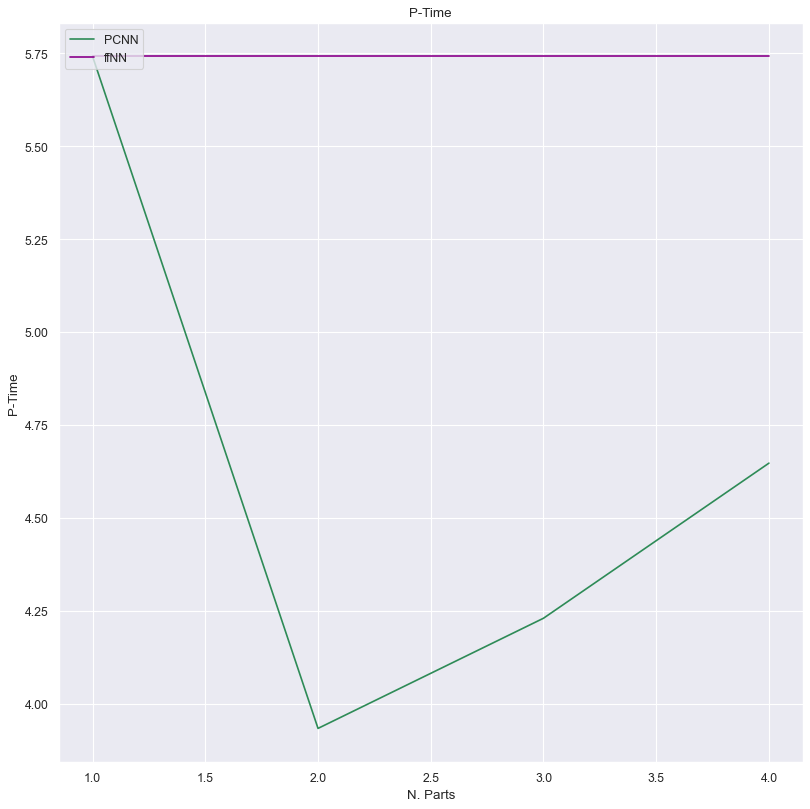

In [16]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times,
         label = 'PCNN',
         color='seagreen')
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta')
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## N-Params

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


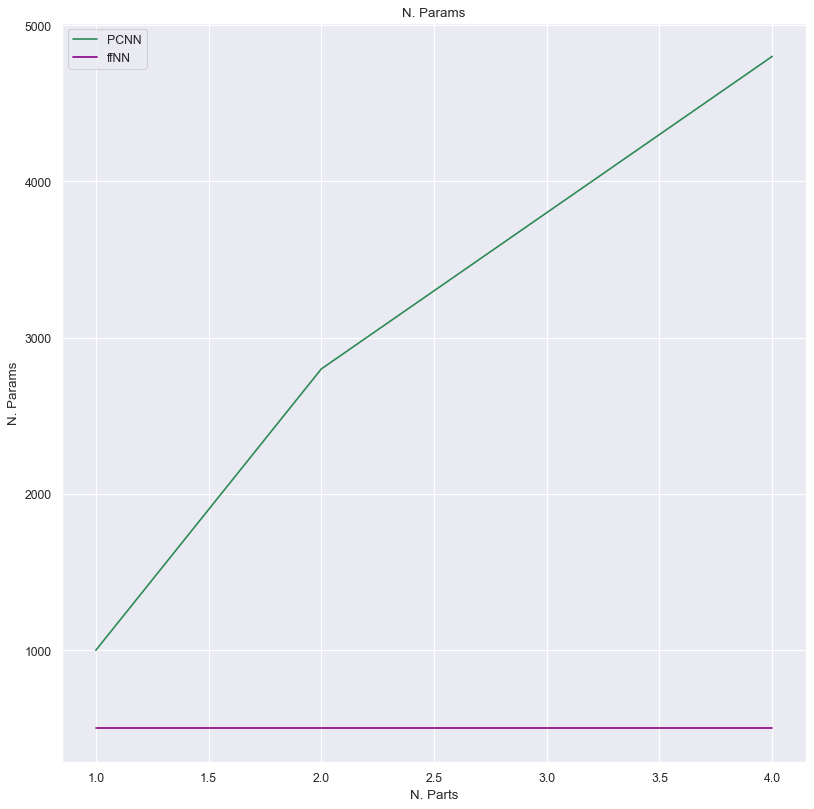

In [17]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params,
         label = 'PCNN',
         color='seagreen')
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta')
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Number of Active Neurons Per Input

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


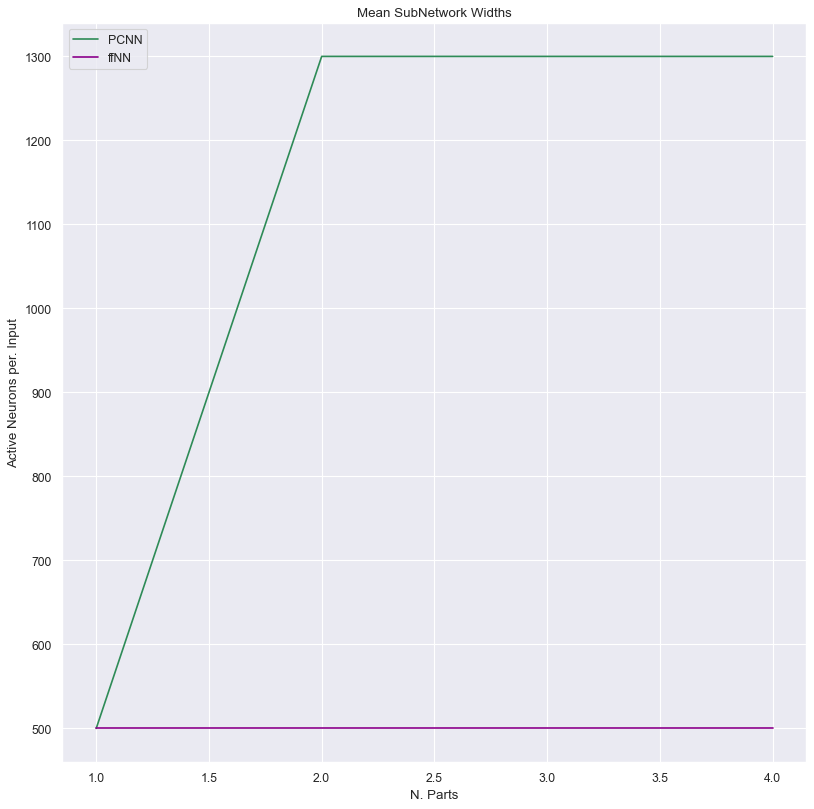

In [18]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean SubNetwork Widths")
plt.xlabel("N. Parts")
plt.ylabel("Active Neurons per. Input")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_per_input,
         label = 'PCNN',
         color='seagreen')
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta')
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Active_Neurons_per_input___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Mean Widths for Sub-Pattern Networks

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean Subpattern Widths")
plt.xlabel("N. Parts")
plt.ylabel("Mean Subpattern Widths")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'PCNN',
         color='seagreen')
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta')
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Mean_Widths___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

---
# Fin
---

---

---